In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from scipy import *
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import traceback
import scipy
from google.colab import drive
drive.mount('/content/drive')
from scipy.io import savemat, loadmat
from scipy import fftpack, linalg
SELECTED_CHANNELS = ['F7','T5', 'F3','P3', 'F4','P4', 'F8','T6', 'Fp1','O1', 'Fp2','O2']
import numpy as np
import os, sys, traceback
from google.colab import drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def tridisolve(d, e, b, overwrite_b=True):
    """Symmetric tridiagonal system solver, from Golub and Van Loan pg 157.

    Note: Copied from NiTime

    Parameters
    ----------

    d : ndarray
      main diagonal stored in d[:]
    e : ndarray
      superdiagonal stored in e[:-1]
    b : ndarray
      RHS vector

    Returns
    -------

    x : ndarray
      Solution to Ax = b (if overwrite_b is False). Otherwise solution is
      stored in previous RHS vector b

    """
    N = len(b)
    # work vectors
    dw = d.copy()
    ew = e.copy()
    if overwrite_b:
        x = b
    else:
        x = b.copy()
    for k in range(1, N):
        # e^(k-1) = e(k-1) / d(k-1)
        # d(k) = d(k) - e^(k-1)e(k-1) / d(k-1)
        t = ew[k - 1]
        ew[k - 1] = t / dw[k - 1]
        dw[k] = dw[k] - t * ew[k - 1]
    for k in range(1, N):
        x[k] = x[k] - ew[k - 1] * x[k - 1]
    x[N - 1] = x[N - 1] / dw[N - 1]
    for k in range(N - 2, -1, -1):
        x[k] = x[k] / dw[k] - ew[k] * x[k + 1]

    if not overwrite_b:
        return x


def tridi_inverse_iteration(d, e, w, x0=None, rtol=1e-8):
    """Perform an inverse iteration.

    This will find the eigenvector corresponding to the given eigenvalue
    in a symmetric tridiagonal system.

    Note: Copied from NiTime

    Parameters
    ----------

    d : ndarray
      main diagonal of the tridiagonal system
    e : ndarray
      offdiagonal stored in e[:-1]
    w : float
      eigenvalue of the eigenvector
    x0 : ndarray
      initial point to start the iteration
    rtol : float
      tolerance for the norm of the difference of iterates

    Returns
    -------
    e: ndarray
      The converged eigenvector

    """
    eig_diag = d - w
    if x0 is None:
        x0 = np.random.randn(len(d))
    x_prev = np.zeros_like(x0)
    norm_x = np.linalg.norm(x0)
    # the eigenvector is unique up to sign change, so iterate
    # until || |x^(n)| - |x^(n-1)| ||^2 < rtol
    x0 /= norm_x
    while np.linalg.norm(np.abs(x0) - np.abs(x_prev)) > rtol:
        x_prev = x0.copy()
        tridisolve(eig_diag, e, x0)
        norm_x = np.linalg.norm(x0)
        x0 /= norm_x
    return x0


def dpss_windows(N, half_nbw, Kmax, low_bias=True, interp_from=None,
                 interp_kind='linear'):
    """Compute Discrete Prolate Spheroidal Sequences.

    Will give of orders [0,Kmax-1] for a given frequency-spacing multiple
    NW and sequence length N.

    Note: Copied from NiTime

    Parameters
    ----------
    N : int
        Sequence length
    half_nbw : float, unitless
        Standardized half bandwidth corresponding to 2 * half_bw = BW*f0
        = BW*N/dt but with dt taken as 1
    Kmax : int
        Number of DPSS windows to return is Kmax (orders 0 through Kmax-1)
    low_bias : Bool
        Keep only tapers with eigenvalues > 0.9
    interp_from : int (optional)
        The dpss can be calculated using interpolation from a set of dpss
        with the same NW and Kmax, but shorter N. This is the length of this
        shorter set of dpss windows.
    interp_kind : str (optional)
        This input variable is passed to scipy.interpolate.interp1d and
        specifies the kind of interpolation as a string ('linear', 'nearest',
        'zero', 'slinear', 'quadratic, 'cubic') or as an integer specifying the
        order of the spline interpolator to use.


    Returns
    -------
    v, e : tuple,
        v is an array of DPSS windows shaped (Kmax, N)
        e are the eigenvalues

    Notes
    -----
    Tridiagonal form of DPSS calculation from:

    Slepian, D. Prolate spheroidal wave functions, Fourier analysis, and
    uncertainty V: The discrete case. Bell System Technical Journal,
    Volume 57 (1978), 1371430
    """
    from scipy import interpolate
    Kmax = int(Kmax)
    W = float(half_nbw) / N
    nidx = np.arange(N, dtype='d')

    # In this case, we create the dpss windows of the smaller size
    # (interp_from) and then interpolate to the larger size (N)
    if interp_from is not None:
        if interp_from > N:
            e_s = 'In dpss_windows, interp_from is: %s ' % interp_from
            e_s += 'and N is: %s. ' % N
            e_s += 'Please enter interp_from smaller than N.'
            raise ValueError(e_s)
        dpss = []
        d, e = dpss_windows(interp_from, half_nbw, Kmax, low_bias=False)
        for this_d in d:
            x = np.arange(this_d.shape[-1])
            I = interpolate.interp1d(x, this_d, kind=interp_kind)
            d_temp = I(np.linspace(0, this_d.shape[-1] - 1, N, endpoint=False))

            # Rescale:
            d_temp = d_temp / np.sqrt(sum_squared(d_temp))

            dpss.append(d_temp)

        dpss = np.array(dpss)

    else:
        # here we want to set up an optimization problem to find a sequence
        # whose energy is maximally concentrated within band [-W,W].
        # Thus, the measure lambda(T,W) is the ratio between the energy within
        # that band, and the total energy. This leads to the eigen-system
        # (A - (l1)I)v = 0, where the eigenvector corresponding to the largest
        # eigenvalue is the sequence with maximally concentrated energy. The
        # collection of eigenvectors of this system are called Slepian
        # sequences, or discrete prolate spheroidal sequences (DPSS). Only the
        # first K, K = 2NW/dt orders of DPSS will exhibit good spectral
        # concentration
        # [see http://en.wikipedia.org/wiki/Spectral_concentration_problem]

        # Here I set up an alternative symmetric tri-diagonal eigenvalue
        # problem such that
        # (B - (l2)I)v = 0, and v are our DPSS (but eigenvalues l2 != l1)
        # the main diagonal = ([N-1-2*t]/2)**2 cos(2PIW), t=[0,1,2,...,N-1]
        # and the first off-diagonal = t(N-t)/2, t=[1,2,...,N-1]
        # [see Percival and Walden, 1993]
        diagonal = ((N - 1 - 2 * nidx) / 2.) ** 2 * np.cos(2 * np.pi * W)
        off_diag = np.zeros_like(nidx)
        off_diag[:-1] = nidx[1:] * (N - nidx[1:]) / 2.
        # put the diagonals in LAPACK "packed" storage
        ab = np.zeros((2, N), 'd')
        ab[1] = diagonal
        ab[0, 1:] = off_diag[:-1]
        # only calculate the highest Kmax eigenvalues
        w = linalg.eigvals_banded(ab, select='i',
                                  select_range=(N - Kmax, N - 1))
        w = w[::-1]

        # find the corresponding eigenvectors via inverse iteration
        t = np.linspace(0, np.pi, N)
        dpss = np.zeros((Kmax, N), 'd')
        for k in range(Kmax):
            dpss[k] = tridi_inverse_iteration(diagonal, off_diag, w[k],
                                              x0=np.sin((k + 1) * t))

    # By convention (Percival and Walden, 1993 pg 379)
    # * symmetric tapers (k=0,2,4,...) should have a positive average.
    # * antisymmetric tapers should begin with a positive lobe
    fix_symmetric = (dpss[0::2].sum(axis=1) < 0)
    for i, f in enumerate(fix_symmetric):
        if f:
            dpss[2 * i] *= -1
    # rather than test the sign of one point, test the sign of the
    # linear slope up to the first (largest) peak
    pk = np.argmax(np.abs(dpss[1::2, :N // 2]), axis=1)
    for i, p in enumerate(pk):
        if np.sum(dpss[2 * i + 1, :p]) < 0:
            dpss[2 * i + 1] *= -1

    # Now find the eigenvalues of the original spectral concentration problem
    # Use the autocorr sequence technique from Percival and Walden, 1993 pg 390

    # compute autocorr using FFT (same as nitime.utils.autocorr(dpss) * N)
    rxx_size = 2 * N - 1
    n_fft = 2 ** int(np.ceil(np.log2(rxx_size)))
    dpss_fft = fftpack.fft(dpss, n_fft)
    dpss_rxx = np.real(fftpack.ifft(dpss_fft * dpss_fft.conj()))
    dpss_rxx = dpss_rxx[:, :N]

    r = 4 * W * np.sinc(2 * W * nidx)
    r[0] = 2 * W
    eigvals = np.dot(dpss_rxx, r)

    if low_bias:
        idx = (eigvals > 0.9)
        if not idx.any():
            warn('Could not properly use low_bias, keeping lowest-bias taper')
            idx = [np.argmax(eigvals)]
        dpss, eigvals = dpss[idx], eigvals[idx]
    assert len(dpss) > 0  # should never happen
    assert dpss.shape[1] == N  # old nitime bug
    return dpss, eigvals

In [ ]:
def getGridIndices(lowerFrequency, upperFrequency, paddedNumDataPoints, samplingFrequency):

  try:

      frequencyResolution = float ( samplingFrequency ) / float ( paddedNumDataPoints )
      
      gridValues = np.arange ( 0, samplingFrequency , frequencyResolution )
      
      gridValues = gridValues[ :paddedNumDataPoints ]

      gridIndices = [index for index, x in enumerate (gridValues) if x>= lowerFrequency and x<= upperFrequency ]

      gridValues = [x for index, x in enumerate (gridValues) if x>= lowerFrequency and x<= upperFrequency ]

  except:
    traceback.print_exc(file=sys.stdout)

  return gridValues , gridIndices



In [ ]:
def analyzeData(datafileDirectory , fileName):
    try:
        print ( " in analyze data ")
        
        layFileName = fileName[:fileName.index(".edf")] + ".lay"
        dataFileName = datafileDirectory + fileName
        channelMap1, commentsObjList1 = parseLayFile(datafileDirectory + layFileName )
        
        filePath = '/content/drive/My Drive/andre/eeg_analysis/data/EEG181.mat'
        data = loadmat(filePath)["eegData"]

        data = data - data.mean(axis=1, keepdims=True)
        numChannels = 16

        beginWin = 0
        endWin = 0

        samplingFrequency = eegFS = 250
        upperFrequency = 100
        lowerFrequency = 0
        timeBandWidth = 4
        timeWindow = 3 # time window in seconds
        STEP_SIZE = 2 # in seconds

        numDataPoints =  timeWindow * samplingFrequency
        stepSize = STEP_SIZE * samplingFrequency
        padding = pad = 0

        winLen = timeWindow * eegFS  

        paddedNumDataPoints = int ( pow ( 2, math.ceil ( np.log2 ( winLen ) + pad) ) )

        numTapers = 2 * timeBandWidth -1
        [tapers, eigenValues] = dpss_windows(int(numDataPoints), float(timeBandWidth), int(numTapers) )

        #numTapers = len(tapers)
        numTapers = 6

        fpass = [lowerFrequency,upperFrequency]

        gridValues, gridIndices = getGridIndices(fpass[0], fpass[1], paddedNumDataPoints, eegFS)

        dataMatrix = []

        spectrumChannelSumData = [] 

        for channelIndex in range(numChannels):

          spectrogramData = []
          channelData = data[channelIndex]

          if channelIndex != 13:
            continue

          print (str(len(  channelData )))
          numWindows = int ( ( len ( channelData ) - numDataPoints + 1) / ( stepSize  ) )
          numWindows = math.floor ( float( len ( channelData ))/ float(numDataPoints) )

          for windowNum in range ( numWindows ) :

              beginWin = windowNum * numDataPoints
              endWin = beginWin + numDataPoints

              windowData = channelData [ beginWin : endWin]

              if len(windowData) == 0:

                break

              spectrumChannelSumData = []
              for taperIndex, taper in enumerate ( tapers ) :

                taperData = [float(a)*float(b) for a,b in zip(windowData,taper)]

                fftData = scipy.fftpack.fft(taperData,paddedNumDataPoints)

                fftData = np.array (fftData)/float(eegFS)
                fftData = fftData[gridIndices]

                spectrumChannelData = np.array([abs(x*conj(x)) for x in fftData])

                plt.figure(1, figsize = (8.5,11))
                plt.title('Spectrogram')

                spectrumChannelSumData.append( list(spectrumChannelData))

              spectrumChannelAvgData = [float(sum(col))/len(col) for col in zip(*spectrumChannelSumData)] 

              spectrogramData.append(list(spectrumChannelAvgData))

          spectrumPSD = [float(sum(col))/len(col) for col in zip(*spectrogramData)]
          spectrumPSD = np.array(spectrumPSD)/100

          plt.clf()

          plt.figure(1, figsize = (8.5,11))
          plt.imshow(np.array(log(spectrogramData)).transpose())

          plt.gca().invert_yaxis()
          plt.axis([0, 416, 0, 100])
          plt.show()    
          break
    except:
            traceback.print_exc(file=sys.stdout)
    return

 in analyze data 
/content/drive/My Drive/andre/eeg_analysis/data/test.lay
 ####### data = ['Z1', 'T4']
 ####### data = ['Z2', 'A2']
 ####### data = ['Z3', 'C3']
 ####### data = ['Z4', 'C4']
 ####### data = ['Z5', 'A1']
 ####### data = ['Z6', 'T3']
 ####### data = ['Z7', 'O1']
 ####### data = ['Z8', 'T5']
 ####### data = ['Z9', 'O2']
 ####### data = ['Z10', 'Cz']
 ####### data = ['Z11', 'F8']
 ####### data = ['Z12', 'T6']
 ####### data = ['Z13', 'Fz']
 ####### data = ['Z14', 'FP2']
 ####### data = ['Z15', 'F7']
 ####### data = ['Z16', 'FP1']
 ####### data = ['Z17', 'CH17']
 ####### data = ['Z18', 'CH18']
 ####### data = ['Z19', 'CH19']
 ####### data = ['Z20', 'CH20']
 ####### data = ['Z21', 'CH21']
 ####### data = ['Z22', 'CH22']
 ####### data = ['Z23', 'CH23']
 ####### data = ['Z24', 'CH24']
 ####### data = ['Z25', 'EKG1']
 ####### data = ['Z26', 'EKG2']
 ####### data = ['Z27', 'Gnd']
 ####### data = ['Z28', 'Ref']
1025.536,0,0,100,re-entered room
['1025.536', '0', '0', '100', 're-ent

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:134: DeprecationWarning: scipy.conj is deprecated and will be removed in SciPy 2.0.0, use numpy.conj instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:149: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead


 window num = 4
 window num = 5
 window num = 6
 window num = 7
 window num = 8
 window num = 9
 window num = 10
 window num = 11
 window num = 12
 window num = 13
 window num = 14
 window num = 15
 window num = 16
 window num = 17
 window num = 18
 window num = 19
 window num = 20
 window num = 21
 window num = 22
 window num = 23
 window num = 24
 window num = 25
 window num = 26
 window num = 27
 window num = 28
 window num = 29
 window num = 30
 window num = 31
 window num = 32
 window num = 33
 window num = 34
 window num = 35
 window num = 36
 window num = 37
 window num = 38
 window num = 39
 window num = 40
 window num = 41
 window num = 42
 window num = 43
 window num = 44
 window num = 45
 window num = 46
 window num = 47
 window num = 48
 window num = 49
 window num = 50
 window num = 51
 window num = 52
 window num = 53
 window num = 54
 window num = 55
 window num = 56
 window num = 57
 window num = 58
 window num = 59
 window num = 60
 window num = 61
 window num = 62
 wi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:178: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead


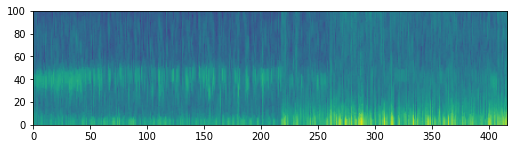

In [ ]:
datafileDirectory = "/content/drive/My Drive/andre/eeg_analysis/data/"
fileName = "test.edf"


analyzeData(datafileDirectory,fileName)